This code is a modified version of the Huggingface library example for question answering. We have run several models for question answering task by changing the hyperparameter and model chechpoints that are mentioned below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# import general libraries

import numpy as np
import pandas as pd
import torch
from google.colab import output
!pip install transformers
!pip install datasets 

output.clear()

In [ ]:
import transformers
from datasets import load_dataset, load_metric
squad_v2 = False  # True if running the model for squad_v2                                              
datasets = load_dataset("squad_v2" if squad_v2 else "squad")
# datasets = datasets.filter(lambda example, indice: indice % 3 == 0 , with_indices=True) # filter to modify the fine-tuning data size
output.clear()
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [ ]:
# Hyperparameters to be changed for various settings
model_checkpoint = "albert-base-v2"        # "roberta-base", "bert-base-uncased", "albert-base-v2", "distilbert-base-cased", "xlm-roberta-base"
batch_size = 16
max_length = 512                           # The maximum length of a feature (question and context)
doc_stride = 64                            # The authorized overlap between two part of the context when splitting it is needed.
learning_rate=2e-5
weight_decay=0.01
save_steps = 8160                          # total_steps / 3
save_total_limit = 5
logging_steps=1000

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

from transformers import RobertaForQuestionAnswering, BertForQuestionAnswering, XLNetForQuestionAnswering,\
                         AlbertForQuestionAnswering, DistilBertForQuestionAnswering, XLMRobertaForQuestionAnswering, TrainingArguments, Trainer
model = AlbertForQuestionAnswering.from_pretrained(model_checkpoint)

output.clear()

# Data Pre-processing

In [ ]:
example = datasets["train"][0]
print(tokenizer(example["question"], example["context"]))

{'input_ids': [2, 20, 1368, 144, 14, 4701, 1044, 9462, 1893, 19, 9995, 19, 29557, 714, 60, 3, 5350, 102, 15, 14, 116, 63, 21, 1405, 925, 9, 11010, 14, 407, 353, 22, 18, 766, 6985, 25, 21, 1872, 4819, 16, 14, 4701, 1044, 9, 1375, 19, 431, 16, 14, 407, 353, 17, 4325, 32, 15, 25, 21, 5504, 4819, 16, 2581, 29, 707, 71, 525, 2541, 29, 14, 4393, 13, 7, 195, 15424, 21, 43, 55, 13, 2636, 2696, 7, 9, 328, 20, 14, 407, 353, 25, 14, 14089, 16, 14, 5938, 582, 9, 1375, 439, 14, 14089, 25, 14, 28498, 15, 21, 13496, 209, 16, 6234, 17, 9138, 9, 32, 25, 21, 13426, 16, 14, 28498, 35, 29557, 15, 714, 113, 14, 4701, 1044, 19985, 102, 682, 20, 1164, 25274, 43, 3286, 86, 12439, 6947, 19, 9995, 9, 35, 14, 241, 16, 14, 407, 1493, 13, 5, 290, 19, 21, 1744, 293, 30, 8534, 120, 203, 12359, 17, 14, 766, 6985, 6, 15, 25, 21, 1935, 15, 773, 1014, 4819, 16, 1044, 9, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
max_l = 512
j = 0
for i, example in enumerate(datasets["train"]):
  l = len(tokenizer(example["question"], example["context"])["input_ids"]) 
  if l > max_l:
    j += 1
print(len(datasets['train']))
print(max_l)
print(j) # number of sequences which have length more than 512


Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors


87599
512
136


Distribution of length of input_id for “Question+ context” length:

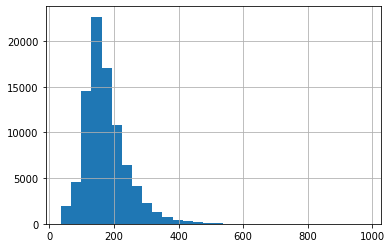

In [ ]:
lengths = []
for i, example in enumerate(datasets["train"]):
  l = len(tokenizer(example["question"], example["context"])["input_ids"]) 
  lengths.append(l)
pd.Series(lengths).hist(bins = 30)

In [ ]:
# lengths=[]
# for j in range(len(df['answers'])):
#   lengths.append(len(list((df['answers'][j]).values())[1][0].split())) 
# pd.Series(lengths).hist(bins = 30)

In [ ]:
# we pad our sequences from the right side
pad_on_right = tokenizer.padding_side == "right"

# Below function tokenizes our examples with truncation and padding, but keep the overflows for long sequences using a stride (dic_stride). 
# This results in one example possible giving several features when a context is long, each of those features having a
# context that overlaps a bit the context of the previous feature.

def prepare_train_features(examples):
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [ ]:
#  apply the prepare_train_features function on all the dataset

tokenized_datasets = datasets.map(prepare_train_features, batched=True, remove_columns=datasets["train"].column_names)

# Fine-tuning

In [ ]:
from transformers import default_data_collator
data_collator = default_data_collator

In [ ]:
## Training on SQuAD 1.1 or 2.0 datasets

args = TrainingArguments(
    f"test-squad",
    evaluation_strategy = "steps",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay = weight_decay,
    logging_steps=logging_steps,
    save_steps = save_steps,
    save_total_limit = save_total_limit
)

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,)

import time                    
start_time = time.time()
trainer.train()

current_time = time.time()
total = current_time - start_time
print('Duration: %.2f minutes' %(total/60))

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
1000,1.448300,1.102932,133.944300,89.351000
2000,1.104700,0.946867,133.917900,89.368000
3000,1.045000,0.932642,134.043200,89.285000
4000,0.951400,0.962637,133.991900,89.319000
5000,0.962300,0.864846,134.000100,89.313000
6000,0.910500,0.854909,133.967700,89.335000
7000,0.887000,0.867684,133.940100,89.353000
8000,0.870600,0.887635,133.943700,89.351000
9000,0.715700,0.923953,133.314900,89.772000
10000,0.669300,0.869832,133.317500,89.771000


Duration: 268.91 minutes


Save and download the fine-tuned model:

In [ ]:
trainer.save_model("test-squad-trained")
from google.colab import files
!zip -r /content/ALBERT-512-squad2.zip /content/test-squad-trained
files.download('/content/ALBERT-512-squad2.zip')

  adding: content/test-squad-trained/ (stored 0%)
  adding: content/test-squad-trained/special_tokens_map.json (deflated 46%)
  adding: content/test-squad-trained/training_args.bin (deflated 46%)
  adding: content/test-squad-trained/spiece.model (deflated 49%)
  adding: content/test-squad-trained/pytorch_model.bin (deflated 7%)
  adding: content/test-squad-trained/tokenizer_config.json (deflated 45%)
  adding: content/test-squad-trained/config.json (deflated 51%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluation on the development set for each epoch:

In this section we will use our save trained model after each epoch (for 3 epochs), to see the performance model in terms of F1 and EM score at the end of each epoch.

In [ ]:
scores = []
epo = 1

# load the saved fine-tuned model at the end of each epoch from local directory
output_dirs = ['./test-squad/checkpoint-8160','./test-squad/checkpoint-16320',
              './test-squad/checkpoint-24480']

for output_dir in output_dirs:
  model = AlbertForQuestionAnswering.from_pretrained(output_dir) # from the saved models
  args = TrainingArguments(
    f"test-squad",
    evaluation_strategy = "steps",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay = weight_decay,
    logging_steps=logging_steps,
    save_steps = save_steps,
    save_total_limit = save_total_limit
    )

  trainer = Trainer(
        model,
        args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        data_collator=data_collator,
        tokenizer=tokenizer,)


  import torch

  for batch in trainer.get_eval_dataloader():

      break
  batch = {k: v.to(trainer.args.device) for k, v in batch.items()}

  with torch.no_grad():
      output = trainer.model(**batch)

  output.keys()

  output.start_logits.shape, output.end_logits.shape
  output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

  # n_best_size: number of the best indices in the start and end logits that we will keep. 
  # After checking if each one is valid, we will sort them by their score and keep the best one.  
  n_best_size = 20 

  import numpy as np

  start_logits = output.start_logits[0].cpu().numpy()
  end_logits = output.end_logits[0].cpu().numpy()
  # Gather the indices the best start/end logits:
  start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
  end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
  valid_answers = []
  for start_index in start_indexes:
      for end_index in end_indexes:
          if start_index <= end_index: # We need to refine that test to check the answer is inside the context
              valid_answers.append(
                  {
                      "score": start_logits[start_index] + end_logits[end_index],
                      "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                  }
              )
  def prepare_validation_features(examples):
      # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
      # in one example possible giving several features when a context is long, each of those features having a
      # context that overlaps a bit the context of the previous feature.
      tokenized_examples = tokenizer(
          examples["question" if pad_on_right else "context"],
          examples["context" if pad_on_right else "question"],
          truncation="only_second" if pad_on_right else "only_first",
          max_length=max_length,
          stride=doc_stride,
          return_overflowing_tokens=True,
          return_offsets_mapping=True,
          padding="max_length",
      )

      # Since one example might give us several features if it has a long context, we need a map from a feature to
      # its corresponding example. This key gives us just that.
      sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

      # We keep the example_id that gave us this feature and we will store the offset mappings.
      tokenized_examples["example_id"] = []

      for i in range(len(tokenized_examples["input_ids"])):
          # Grab the sequence corresponding to that example (to know what is the context and what is the question).
          sequence_ids = tokenized_examples.sequence_ids(i)
          context_index = 1 if pad_on_right else 0

          # One example can give several spans, this is the index of the example containing this span of text.
          sample_index = sample_mapping[i]
          tokenized_examples["example_id"].append(examples["id"][sample_index])

          # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
          # position is part of the context or not.
          tokenized_examples["offset_mapping"][i] = [
              (o if sequence_ids[k] == context_index else None)
              for k, o in enumerate(tokenized_examples["offset_mapping"][i])
          ]

      return tokenized_examples


  validation_features = datasets["validation"].map(
      prepare_validation_features,
      batched=True,
      remove_columns=datasets["validation"].column_names
  )

  raw_predictions = trainer.predict(validation_features)
  validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

  max_answer_length = 30 # maximum length that the output answer can be

  start_logits = output.start_logits[0].cpu().numpy()
  end_logits = output.end_logits[0].cpu().numpy()
  offset_mapping = validation_features[0]["offset_mapping"]
  # The first feature comes from the first example.
  context = datasets["validation"][0]["context"]

  # Gather the indices the best start/end logits:
  start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
  end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
  valid_answers = []
  for start_index in start_indexes:
      for end_index in end_indexes:
          # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
          # to part of the input_ids that are not in the context.
          if (
              start_index >= len(offset_mapping)
              or end_index >= len(offset_mapping)
              or offset_mapping[start_index] is None
              or offset_mapping[end_index] is None
          ):
              continue
          # Don't consider answers with a length that is either < 0 or > max_answer_length.
          if end_index < start_index or end_index - start_index + 1 > max_answer_length:
              continue
          if start_index <= end_index: # We need to refine that test to check the answer is inside the context
              start_char = offset_mapping[start_index][0]
              end_char = offset_mapping[end_index][1]
              valid_answers.append(
                  {
                      "score": start_logits[start_index] + end_logits[end_index],
                      "text": context[start_char: end_char]
                  }
              )

  valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
  valid_answers
  datasets["validation"][0]["answers"]
  import collections

  examples = datasets["validation"]
  features = validation_features

  example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
  features_per_example = collections.defaultdict(list)
  for i, feature in enumerate(features):
      features_per_example[example_id_to_index[feature["example_id"]]].append(i)


  from tqdm.auto import tqdm

  def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
      all_start_logits, all_end_logits = raw_predictions
      # Build a map example to its corresponding features.
      example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
      features_per_example = collections.defaultdict(list)
      for i, feature in enumerate(features):
          features_per_example[example_id_to_index[feature["example_id"]]].append(i)

      # The dictionaries we have to fill.
      predictions = collections.OrderedDict()

      print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

      # Loop over all the examples!
      for example_index, example in enumerate(tqdm(examples)):
          # Those are the indices of the features associated to the current example.
          feature_indices = features_per_example[example_index]

          min_null_score = None # Only used if squad_v2 is True.
          valid_answers = []
          
          context = example["context"]
          # Looping through all the features associated to the current example.
          for feature_index in feature_indices:
              # We grab the predictions of the model for this feature.
              start_logits = all_start_logits[feature_index]
              end_logits = all_end_logits[feature_index]
              # This is what will allow us to map some the positions in our logits to span of texts in the original context.
              offset_mapping = features[feature_index]["offset_mapping"]

              # Update minimum null prediction.
              cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
              feature_null_score = start_logits[cls_index] + end_logits[cls_index]
              if min_null_score is None or min_null_score < feature_null_score:
                  min_null_score = feature_null_score

              # Go through all possibilities for the `n_best_size` greater start and end logits.
              start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
              end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
              for start_index in start_indexes:
                  for end_index in end_indexes:
                      # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                      # to part of the input_ids that are not in the context.
                      if (
                          start_index >= len(offset_mapping)
                          or end_index >= len(offset_mapping)
                          or offset_mapping[start_index] is None
                          or offset_mapping[end_index] is None
                      ):
                          continue
                      # Don't consider answers with a length that is either < 0 or > max_answer_length.
                      if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                          continue

                      start_char = offset_mapping[start_index][0]
                      end_char = offset_mapping[end_index][1]
                      valid_answers.append(
                          {
                              "score": start_logits[start_index] + end_logits[end_index],
                              "text": context[start_char: end_char]
                          }
                      )
          
          if len(valid_answers) > 0:
              best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
          else:
              # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
              # failure.
              best_answer = {"text": "", "score": 0.0}
          
          # Let's pick our final answer: the best one or the null answer (only for squad_v2)
          if not squad_v2:
              predictions[example["id"]] = best_answer["text"]
          else:
              answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
              predictions[example["id"]] = answer

      return predictions


  final_predictions = postprocess_qa_predictions(datasets["validation"], validation_features, raw_predictions.predictions)

  # use F1 and EM scores for moddel evaluations
  metric = load_metric("squad_v2" if squad_v2 else "squad")
  if squad_v2:
      formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
      references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]]
      mid_scores = metric.compute(predictions=formatted_predictions, references=references)
      F1 = mid_scores['f1']
      EM = mid_scores['exact']
  else:
      formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
      references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]]
      mid_scores = metric.compute(predictions=formatted_predictions, references=references)
      F1 = mid_scores['f1']
      EM = mid_scores['exact_match']

  results = [model_checkpoint, epo, F1, EM]
  scores.append(results)
  epo += 1
final_scores = pd.DataFrame(scores, columns=['Model','Epoch', 'F1', 'EM'])
final_scores.to_csv('final_scores.csv')
final_scores

Post-processing 11873 example predictions split into 11968 features.


Loading cached processed dataset at /root/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/9cac55034b086140f0649ecb5c604d09d7da2f2f5b73a90caa2e2bcc1f5cac09/cache-cf6a0d08b3b129f9.arrow


Post-processing 11873 example predictions split into 11968 features.


Loading cached processed dataset at /root/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/9cac55034b086140f0649ecb5c604d09d7da2f2f5b73a90caa2e2bcc1f5cac09/cache-cf6a0d08b3b129f9.arrow


Post-processing 11873 example predictions split into 11968 features.


,Model,Epoch,F1,EM
0,albert-base-v2,1,79.883159,76.956119
1,albert-base-v2,2,80.457893,77.124568
2,albert-base-v2,3,81.734600,78.371094


# An example output

In this section, we give the model a question and a context. We will see the output answer as text.

In [ ]:
output_dir = './'
model = AlbertForQuestionAnswering.from_pretrained(output_dir)

In [ ]:
# Apply the tokenizer to the input text, treating them as a text-pair.
question = "whose piano sonata has two movements?"
context = "Piano sonatas are usually written in three or four movements, although some piano sonatas have been written with a single movement (Scarlatti, Liszt, Scriabin, Medtner, Berg), others with two movements (Haydn, Beethoven), some contain five (Brahms' Third Piano Sonata) or even more movements"

input_ids = tokenizer(question,context)
print(input_ids)
input_ids=input_ids['input_ids']

tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id...
for token, id in zip(tokens, input_ids):
    
    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')

# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)


outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                 token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

start_scores = outputs.start_logits
end_scores = outputs.end_logits
# Find the tokens with the highest `start` and `end` logits.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

{'input_ids': [2, 1196, 1925, 13959, 63, 81, 4889, 60, 3, 1925, 13959, 18, 50, 951, 642, 19, 132, 54, 222, 4889, 15, 419, 109, 1925, 13959, 18, 57, 74, 642, 29, 21, 345, 1018, 13, 5, 18, 1367, 25135, 49, 15, 27088, 15, 4729, 2548, 4772, 15, 9488, 12311, 15, 12314, 6, 15, 654, 29, 81, 4889, 13, 5, 12622, 43, 103, 15, 18268, 6, 15, 109, 3717, 355, 13, 5, 19500, 18, 22, 422, 1925, 13959, 6, 54, 166, 91, 4889, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
[CLS]             2
▁whose        1,196
▁piano        

## Plot the start and end of the answer logits for each token in the sequence (question + context)

We will select the token with highest logit for the start and highest logit for the end of answer sequence. The final anser would be all tokens between these two selected tokens (included).

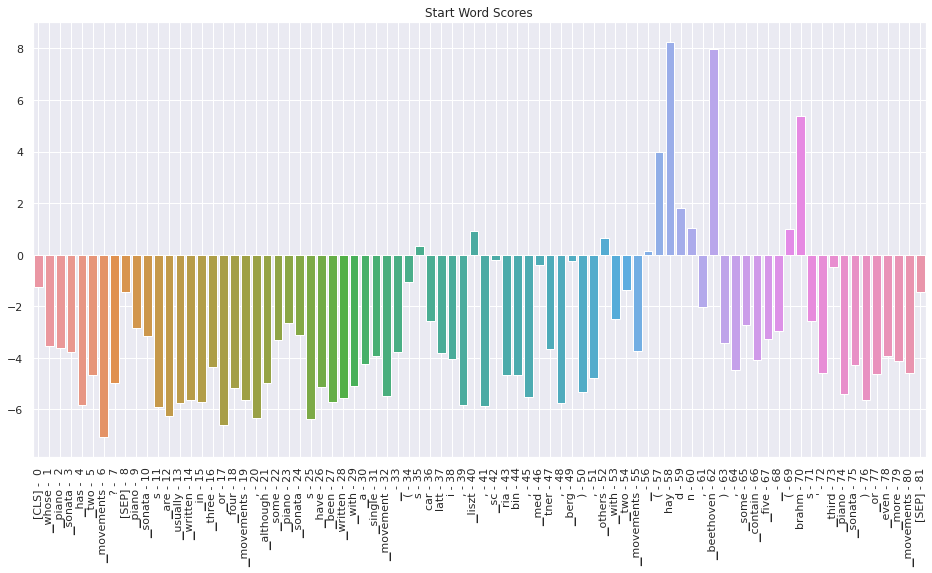

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)


# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

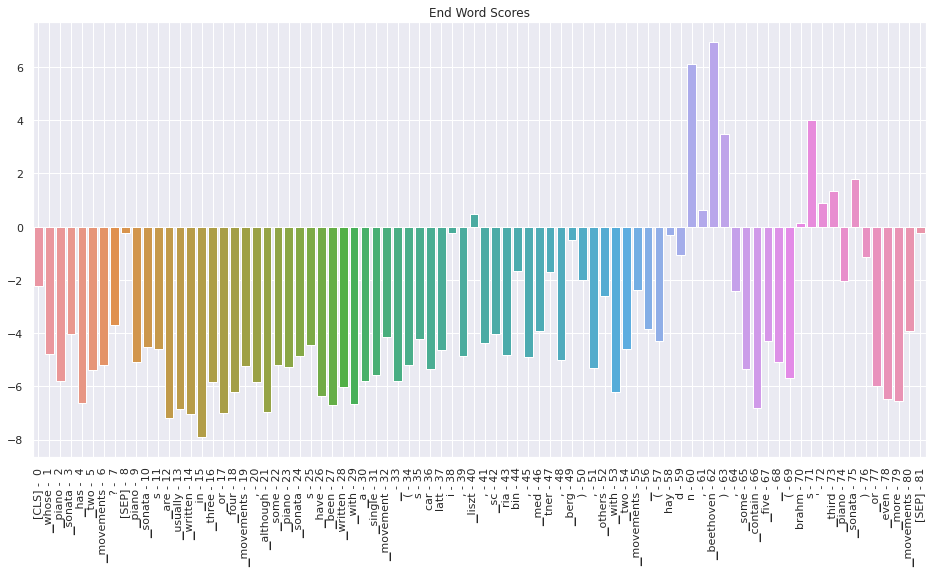

In [ ]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

Now we can see both start and end logits in one plot:

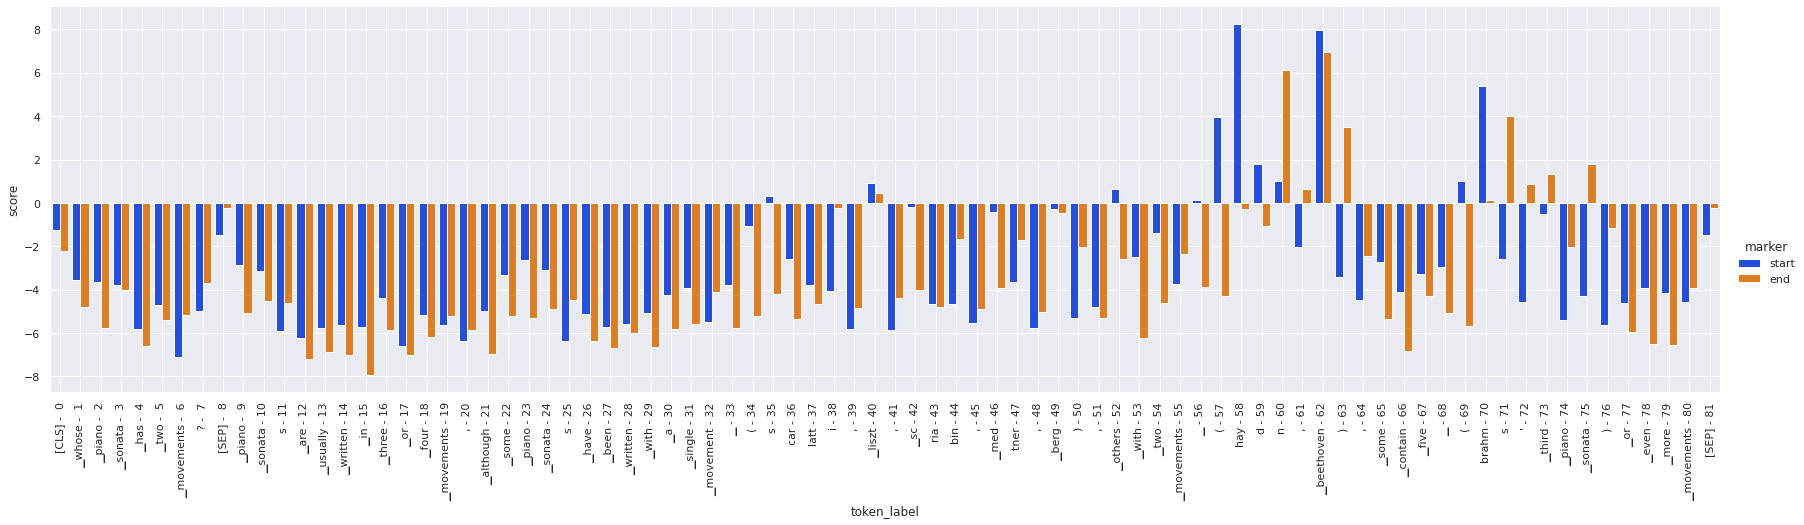

In [ ]:
import pandas as pd

# Creating a dataframe where each token will have two rows, one for its start score and one for its end score.

scores = []
for (i, token_label) in enumerate(token_labels):

    # Add the token's start score as one row.
    scores.append({'token_label': token_label, 
                   'score': s_scores[i],
                   'marker': 'start'})
    
    # Add  the token's end score as another row.
    scores.append({'token_label': token_label, 
                   'score': e_scores[i],
                   'marker': 'end'})
    
df = pd.DataFrame(scores)
g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                kind="bar", height=6, aspect=4, palette ="bright" )
# Turn the xlabels vertical.
g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
g.ax.grid(True)

The End!